## gotoflux() function

* 09/21

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from glob import glob
import getpass

#fitfiles = glob('new_example_input/*.fits')
#fitfiles = glob('/home/jp/data/transit/c14/*.fits.gz')

folders = glob('/home/jp/github/transit/cranky/output/*')
folders

['/home/jp/github/transit/cranky/output/figs',
 '/home/jp/github/transit/cranky/output/20159908',
 '/home/jp/github/transit/cranky/output/24866269',
 '/home/jp/github/transit/cranky/output/20145408',
 '/home/jp/github/transit/cranky/output/chain.npy.gz']

## raw

In [4]:
import pandas as pd
from astropy.stats import sigma_clip

d = glob(os.path.join(folders[2],'*raw*.txt'))[0]
df = pd.read_csv(d, skiprows=1, delimiter=' ', names=['t','f','x','y'])
df['f_clip'] = sigma_clip(df.f, sigma_upper=2,sigma_lower=10)
df['fmed'] = df.f_clip.apply(lambda x: x/np.nanmedian(df.f_clip))
df['f_mask'] = df.fmed[df.fmed.apply(lambda x: (x > 0.9) & (x < 1.1))]
df.head()

,t,f,x,y,f_clip,fmed,f_mask
0,3072.723055,3818319.0,572.403585,966.464704,3818319.0,0.990996,0.990996
1,3072.743489,3821228.0,572.406562,966.464730,3821228.0,0.991751,0.991751
2,3072.763923,3824836.0,572.409431,966.463025,3824836.0,0.992687,0.992687
3,3072.784356,3827722.0,572.413336,966.462434,3827722.0,0.993436,0.993436
4,3072.804790,3830503.0,572.419457,966.461292,3830503.0,0.994158,0.994158


39


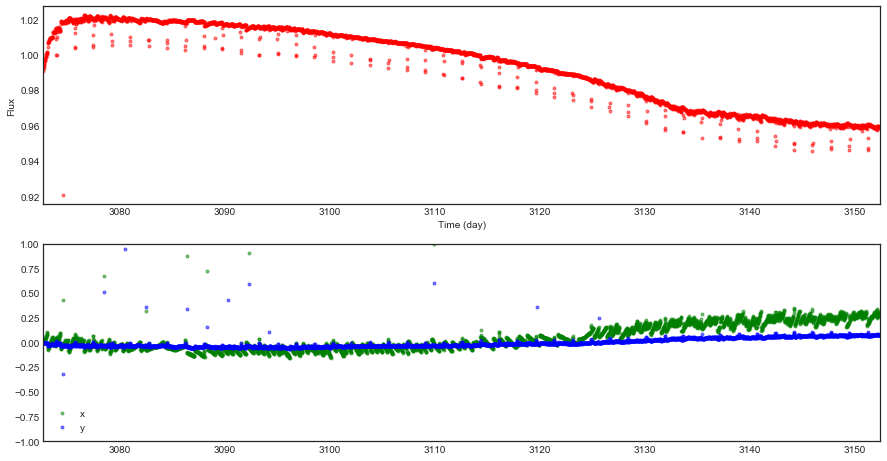

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(2,1,figsize=(15,8))
#ax[0].plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax[0].plot(df.t, df.f_mask,'.', alpha=0.5, color='r', marker='.')
ax[0].set_ylabel('Flux')
ax[0].set_xlabel('Time (day)')
#ax[0].set_ylim([np.median(df.fmed)-0.1,np.median(df.fmed)+0.1])
ax[0].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
#centroid drift
ax[1].plot(df.t, df.x.apply(lambda x: x-df.x.iloc[0]),'.', alpha=0.5, color='g', marker='.', label='x')
ax[1].plot(df.t, df.y.apply(lambda x: x-df.y.iloc[0]),'.', alpha=0.5, color='b', marker='.', label='y')
ax[1].set_ylim([-1,1])
ax[1].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
plt.legend()

print(np.isnan(df.f_mask).sum())

In [6]:
x=df.x/np.median(df.x)
y=df.y/np.median(df.y)
f=df.f/np.median(df.f)
t=df.t

#design matrix
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]

In [7]:
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f)

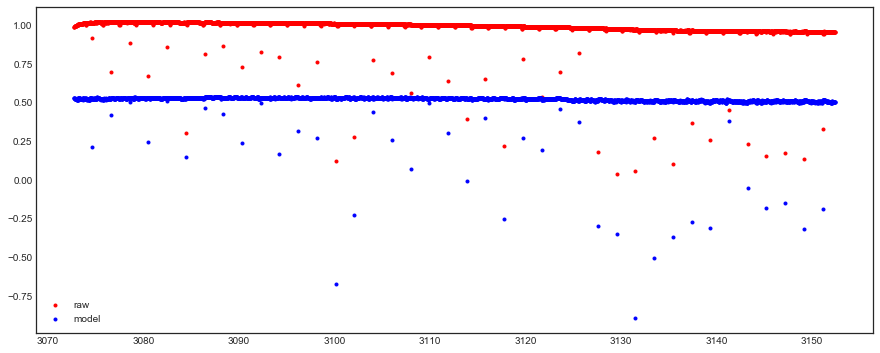

In [8]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)
ax.plot(t,f,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

In [9]:
#sigma clipping
from astropy.stats import sigma_clip

fmask= sigma_clip(f, sigma=3).mask
xmask= sigma_clip(x, sigma=3).mask
ymask= sigma_clip(y, sigma=3).mask

zz = np.c_[fmask, xmask, ymask]
# idx = zz.sum(axis=1) != 0
# idx.sum()
mask=zz.any(axis=1)
f,x,y,t=f[~mask],x[~mask],y[~mask],t[~mask]

In [10]:
#model
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f)

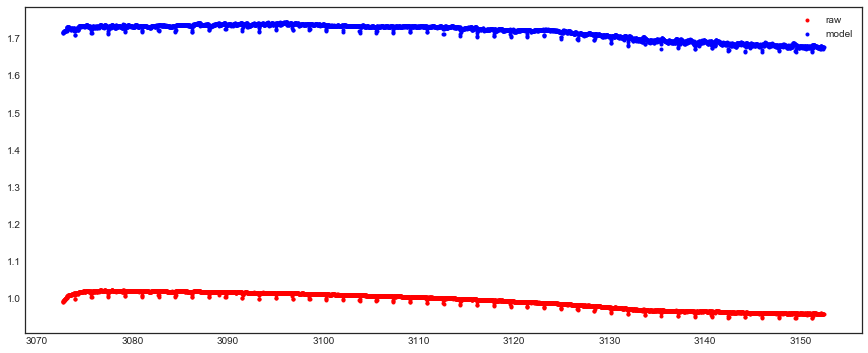

In [11]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)
ax.plot(t,f,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

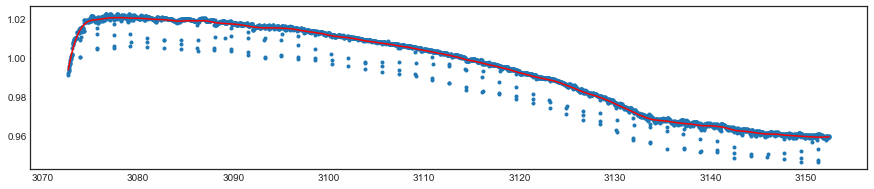

In [12]:
#fit spline

from scipy.interpolate import Rbf
rbfi = Rbf(t, f, function='quintic', smooth=100)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f, '.')
ax.plot(t, rbfi(t), 'r-')

(0.98, 1.01)

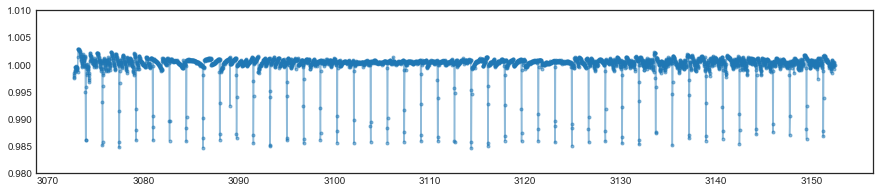

In [13]:
#detrended lc

fig, ax = pl.subplots(1,1,figsize=(15,3))

f_cd = f / rbfi(t)
pl.plot(t,f_cd,'.-', alpha=0.5 )
ax.set_ylim(0.98,1.01)

In [14]:
#sigma clipping
from astropy.stats import sigma_clip

fmask= sigma_clip(f_cd, sigma=3).mask
xmask= sigma_clip(x, sigma=3).mask
ymask= sigma_clip(y, sigma=3).mask

zz = np.c_[fmask, xmask, ymask]
# idx = zz.sum(axis=1) != 0
# idx.sum()
mask=zz.any(axis=1)
f_cdc,x_cdc,y_cdc,t_cdc=f_cd[~mask],x[~mask],y[~mask],t[~mask]

In [19]:
from k2crank import periodfinder
import numpy as np

#inputpath='output2/248662696/lightcurve_raw_nothrusters_24866269.txt'
inputpath='tf.txt'
lc = np.loadtxt(inputpath)
t,f=lc[:,0],lc[:,1]
tf,ff,period,freqlist,powers = periodfinder.get_period(t,f,outputpath='newout',starname='248662696')

ImportError: cannot import name auxiliaries

In [ ]:
def extract_individual(star, p, t0, width=1):

    t, f = star.time, star.flux
    idx = np.isfinite(t) & np.isfinite(f)
    t, f = t[idx], f[idx]

    tns =  get_tns(t, p, t0)

    transits = []
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        if idx.sum() == 0:
            continue
        ti = t[idx].tolist()
        fi = f[idx].tolist()
        transits.append((ti,fi))

    return transits

In [ ]:
pl.plot(tf,ff)

In [ ]:
def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns

In [ ]:
tns=get_tns(t,period,t0=3000)
tns[0]

In [52]:
def fold_data(t,y,period):
  # simple module to fold data based on period

    folded = t % period
    inds = np.array(folded).argsort()
    t_folded = folded[inds]
    y_folded = y[inds]

    return t_folded,y_folded

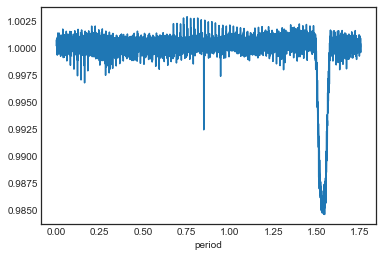

In [69]:
tt,ff=fold_data(t,f,period)
pl.plot(tt,ff)
pl.xlabel('period')

In [ ]:
from pytransit import MandelAgol
MA = MandelAgol()

def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def model_u(theta, t, p):
    k,tc,a_s,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a_s, i)
    return m

#k,tc,a,i,u1,u2
k=np.sqrt(1-0.985)
a_s = scaled_a(period, )
theta=[k,tc,a_s,i,0.2.,0.2]

model_u(theta, tt, period)

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(t, f, 'ko', t, model_u(theta, t, p), 'r-');

In [ ]:
import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

print ("cost before: {}".format(obj(theta, t, p, f)))
res = op.minimize(obj, theta, args=(t, p, f), method='nelder-mead')

print ("cost after: {}".format(obj(res.x, t, p, f)))

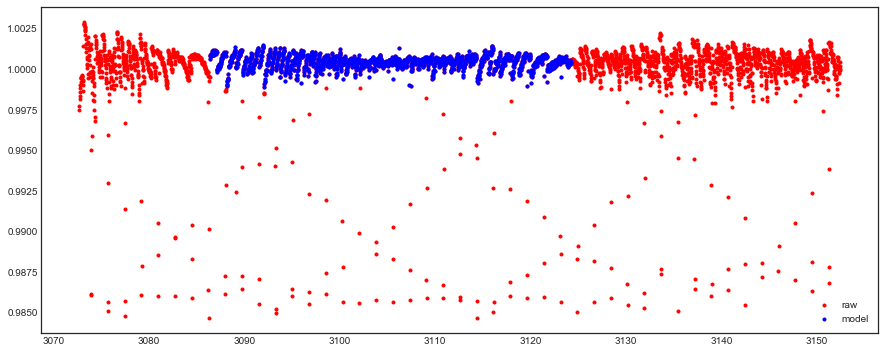

In [15]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
p1,p2=590,2340
ax.plot(t,f_cd,'r.',label='raw')
ax.plot(t_cdc[p1:p2],f_cdc[p1:p2],'b.',label='model')
ax.legend()

In [16]:
idx=[590,2340]

chunk1=f_cdc[:idx[0]]
chunk2=f_cdc[idx[0]:idx[1]]
chunk3=f_cdc[idx[1]:]

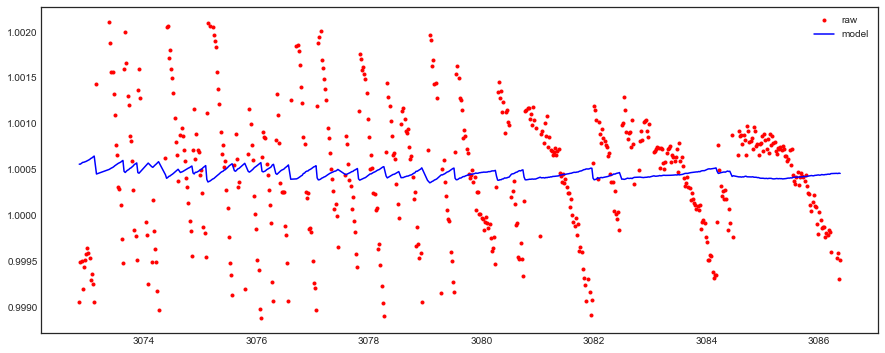

In [30]:
from scipy import optimize as op

X = np.c_[x_cdc[:idx[0]],y_cdc[:idx[0]],
          x_cdc[:idx[0]]*y_cdc[:idx[0]],
          x_cdc[:idx[0]]**2,y_cdc[:idx[0]]**2]#,
         #np.ones_like(x_cdc[:idx[0]])] #bias

#regularization
reg = 1e-3
I=np.identity(X.shape[-1])
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+reg*I),X.T),chunk1)

fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat1_ls=np.dot(X,beta)

ax.plot(t_cdc[:idx[0]],chunk1,'r.',label='raw')
ax.plot(t_cdc[:idx[0]],f_hat1_ls,'b-',label='model')
ax.legend()

In [56]:
#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = -10
    sigma = np.exp(logsigma)
    y_model = (theta*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0]

args = (X, f_cdc[idx[0]])
nll = lambda *x: -log_like(*x)

In [ ]:
nll(x0, X, chunk1)

In [32]:
opt = op.minimize(nll, x0, args=args, method='nelder-mead')

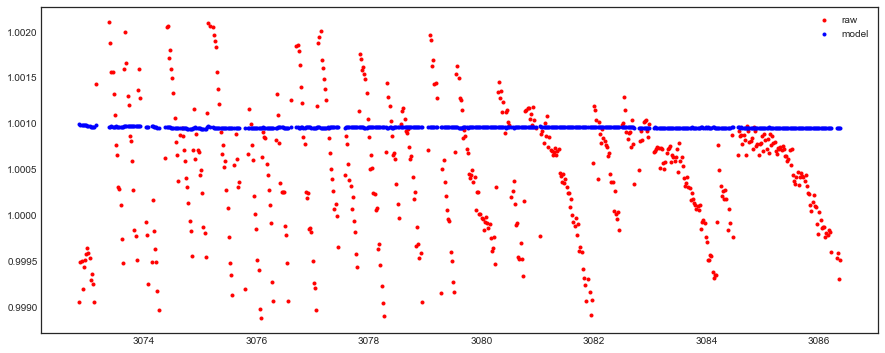

In [33]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat1=(opt.x*X).sum(axis=1)

ax.plot(t_cdc[:idx[0]],chunk1,'r.',label='raw')
ax.plot(t_cdc[:idx[0]],f_hat1,'b.',label='model')
ax.legend()

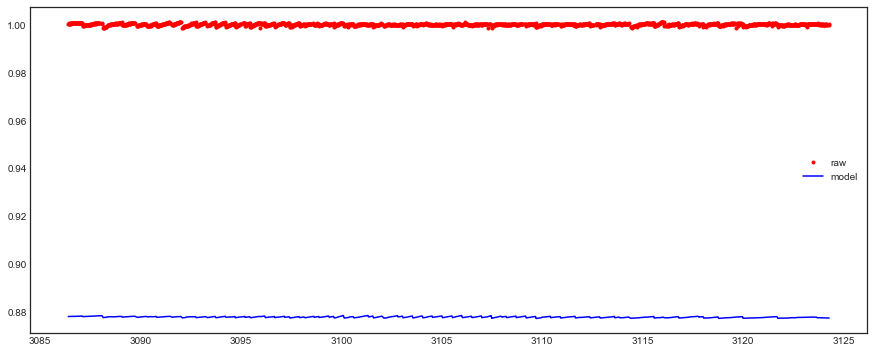

In [58]:
from scipy import optimize as op

X = np.c_[x_cdc[idx[0]:idx[1]],y_cdc[idx[0]:idx[1]],
          x_cdc[idx[0]:idx[1]]*y_cdc[idx[0]:idx[1]],
          x_cdc[idx[0]:idx[1]]**2,y_cdc[idx[0]:idx[1]]**2,
         np.ones_like(x_cdc[idx[0]:idx[1]])]

beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),chunk2)

fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat2_ls=np.dot(X,beta)

ax.plot(t_cdc[idx[0]:idx[1]],chunk2,'r.',label='raw')
ax.plot(t_cdc[idx[0]:idx[1]],f_hat2_ls,'b-',label='model')
ax.legend()

In [21]:
#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = -1
    sigma = np.exp(logsigma)
    y_model = (theta*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0]

args = (X, chunk2)
nll = lambda *x: -log_like(*x)

In [22]:
nll(x0, X, chunk2)

4721.3946241805152

In [23]:
opt = op.minimize(nll, x0, args=args, method='nelder-mead')

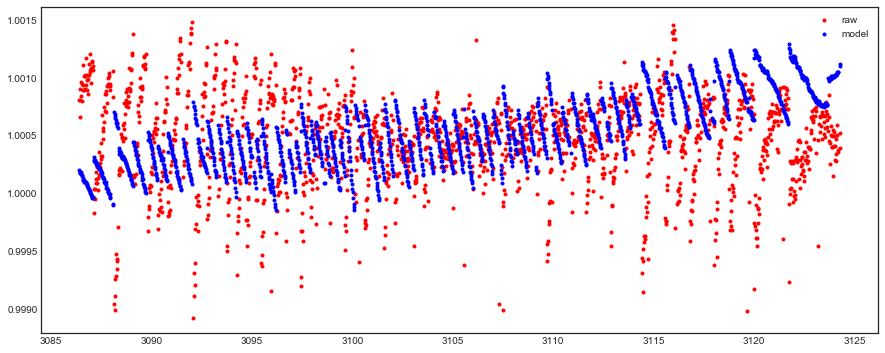

In [24]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat2=(opt.x*X).sum(axis=1)

ax.plot(t_cdc[idx[0]:idx[1]],chunk2,'r.',label='raw')
ax.plot(t_cdc[idx[0]:idx[1]],f_hat2,'b.',label='model')
ax.legend()

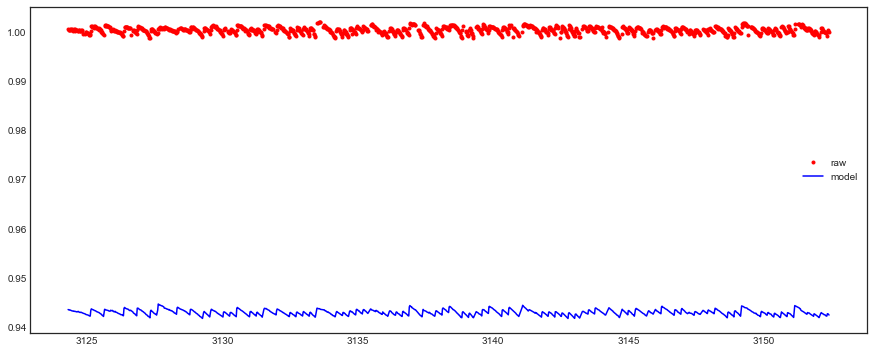

In [60]:
from scipy import optimize as op

X = np.c_[x_cdc[idx[1]:],y_cdc[idx[1]:],
          x_cdc[idx[1]:]*y_cdc[idx[1]:],
          x_cdc[idx[1]:]**2,y_cdc[idx[1]:]**2]#,
         #np.ones_like(x_cdc[idx[1]:])] #bias

beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),chunk3)

fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat3_ls=np.dot(X,beta)

ax.plot(t_cdc[idx[1]:],chunk3,'r.',label='raw')
ax.plot(t_cdc[idx[1]:],f_hat3_ls,'b-',label='model')
ax.legend()

In [25]:
#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = -1
    sigma = np.exp(logsigma)
    y_model = (theta*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0]

args = (X, chunk3)
nll = lambda *x: -log_like(*x)

In [26]:
nll(x0, X, chunk3)

3442.3050441040969

In [27]:
opt = op.minimize(nll, x0, args=args, method='nelder-mead')

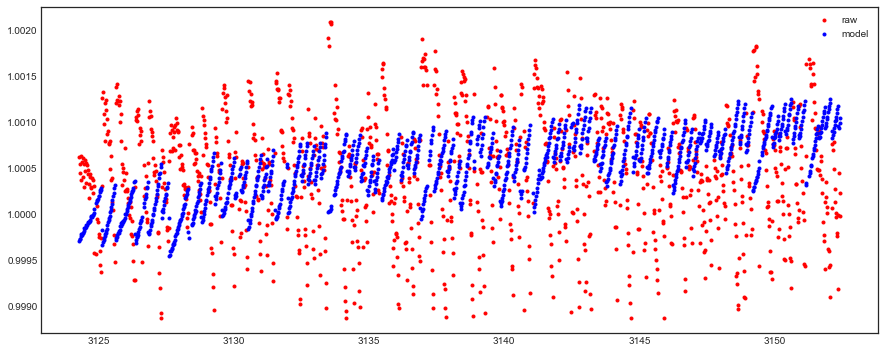

In [28]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat3=(opt.x*X).sum(axis=1)

ax.plot(t_cdc[idx[1]:],chunk3,'r.',label='raw')
ax.plot(t_cdc[idx[1]:],f_hat3,'b.',label='model')
ax.legend()

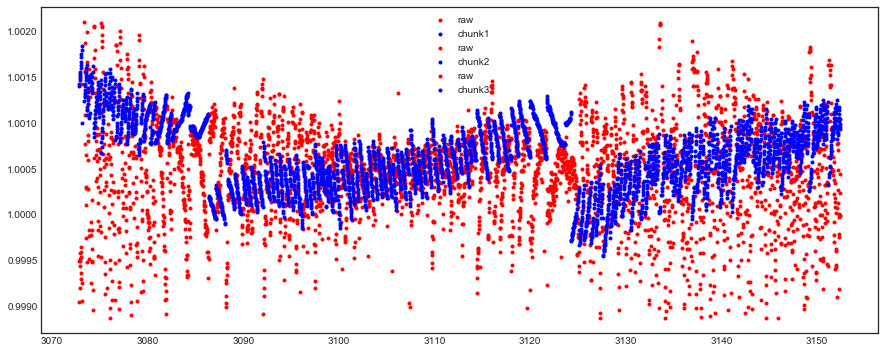

In [29]:
fig,ax = pl.subplots(1,1,figsize=(15,6))

ax.plot(t_cdc[:idx[0]],chunk1,'r.',label='raw')
ax.plot(t_cdc[:idx[0]],f_hat1,'b.',label='chunk1')
ax.plot(t_cdc[idx[0]:idx[1]],chunk2,'r.',label='raw')
ax.plot(t_cdc[idx[0]:idx[1]],f_hat2,'b.',label='chunk2')
ax.plot(t_cdc[idx[1]:],chunk3,'r.',label='raw')
ax.plot(t_cdc[idx[1]:],f_hat3,'b.',label='chunk3')
ax.legend()